In [1]:
from numpy import *
from scipy import *
import numpy as np
from matplotlib import *

from scipy import integrate
from scipy import interpolate
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import xlrd

rc('text',usetex = True)
rc('font', family='serif',size = 12)

In [2]:
def Properties(SpecHeat,dTad,B_l_int,B_h_int,T,N_ml): #Get the properties on the low and high field

    C_l = zeros([N_ml,len(T)])
    C_h = zeros([N_ml,len(T)])
    dT_l = zeros([N_ml,len(T)])
    dT_h = zeros([N_ml,len(T)])
    

    for i in range(K):
        if B_exp[i] == B_l_int:
            for j in range(N_ml):
                C_l[j][i]=C[j,i]
                dT_l[j][i]=dT[j,i]

        if B_exp[i] == B_h_int and B_exp[i-1]< B_h_int:
            A = i
        if B_exp[i] == B_h_int:
            for j in range(N_ml):
                C_h[j][i-A]=C[j,i]
                dT_h[j][i-A]=dT[j,i]
                
    return(C_l,C_h,dT_l,dT_h)

In [3]:
def SubMetrics(Th,Tc,T_l,T_layer,L_layer,C_h,C_l,dT_ad,dT_ad_d):

    Th = 312
    Tc = 282

    C_mag = []
    C_dmag = []
    dT_mag = []
    dT_dmag = []

    T_int = np.arange(Tc,Th+0.01,0.1)


    #T_layer = np.arange(282,310.1,30/(15))
    #L_layer = (100/len(T_layer))*ones(len(T_layer))
    N_l = len(T_layer)

    A = np.int((Tc - min(T_exp))/0.1)



    T_t = []
    L = 0

    for i in range(N_l):
        L = L + L_layer[i]
        T_tr = Tc + 0.001 +L/100*(Th-Tc)
        T_t.append(T_tr)

    k = 0    
    for i in range (len(T_int)):
        #print(T_int[i])
        if T_int[i] <=T_t[k]:
            #print(T_int[i],T_t[k])
            for j in range(len(T_l)):
                #print(T_layer[k],T_l[j])
                if T_layer[k] >= T_l[j] and T_layer[k] < T_l[j+1]:
                    #print('Hello')
                    #print(T_int[i],T_t[k],T_layer[k],T_l[j],T_l[j+1])
                    C_mag.append(C_h[j+1][int(i+A)]-(C_h[j+1][int(i+A)]-C_h[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
                    C_dmag.append(C_l[j+1][int(i+A)]-(C_l[j+1][int(i+A)]-C_l[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
                    dT_mag.append(dT_ad[j+1][int(i+A)]-(dT_ad[j+1][int(i+A)]-dT_ad[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
                    dT_dmag.append(dT_ad_d[j+1][int(i+A)]-(dT_ad_d[j+1][int(i+A)]-dT_ad_d[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
                    #print(T_int[i],C_h[j+1][int(i+A)],C_h[j][int(i+A)],(C_h[j+1][int(i+A)]-(C_h[j+1][int(i+A)]-C_h[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j])))
        else:
            for j in range(len(T_l)):
                if T_layer[k+1] >= T_l[j] and T_layer[k+1] < T_l[j+1]:
                    C_mag.append(C_h[j][int(i+A)]+(C_h[j+1][int(i+A)]-C_h[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
                    C_dmag.append(C_l[j][int(i+A)]+(C_l[j+1][int(i+A)]-C_l[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
                    dT_mag.append(dT_ad[j][int(i+A)]+(dT_ad[j+1][int(i+A)]-dT_ad[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
                    dT_dmag.append(dT_ad_d[j][int(i+A)]+(dT_ad_d[j+1][int(i+A)]-dT_ad_d[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
                    #print(T_int[i],C_h[j+1][int(i+A)],C_h[j][int(i+A)],T_l[j+1],T_l[j],T_layer[k],(C_h[j+1][int(i+A)]-(C_h[j+1][int(i+A)]-C_h[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j])))
            k = k + 1
            
    return (C_mag,C_dmag,dT_mag,dT_dmag)

In [4]:
def Parameters(C_mag,C_dmag,dT_mag,dT_dmag,T_int):
    C_mag_mean   = integrate.simps(C_mag,T_int)/(max(T_int)-min(T_int))
    C_dmag_mean  = integrate.simps(C_dmag,T_int)/(max(T_int)-min(T_int))
    
    dT_mag_mean  = integrate.simps(dT_mag,T_int)/(max(T_int)-min(T_int))
    dT_dmag_mean = integrate.simps(dT_dmag,T_int)/(max(T_int)-min(T_int))
    
    CdT_mag_mean   = integrate.simps(np.array(C_mag)*np.array(dT_mag),T_int)/(max(T_int)-min(T_int))
    CdT_dmag_mean  = integrate.simps(np.array(C_dmag)*np.array(dT_dmag),T_int)/(max(T_int)-min(T_int))
    return C_mag_mean, C_dmag_mean, dT_mag_mean,dT_dmag_mean,CdT_mag_mean,CdT_dmag_mean

In [5]:
def Metrics (SpecHeat,dTad,B_l_int,B_h_int,T_arg,N_ml,Th,Tc,T_l,T_layer,L_layer):
    (C_l,C_h,dT_l,dT_h) = Properties(SpecHeat,dTad,B_l_int,B_h_int,T_arg,N_ml) #Properties of low and high fields
    dT_ad = np.array(dT_h)-np.array(dT_l)
             
    T_dem = zeros([N_ml,len(T_arg)])
    for j in range(N_ml):
        T_dem[j] = T_arg + dT_ad[j]
             
    dT_ad_d = np.zeros([N_ml,len(T_arg)])
    for i in range(N_ml):
        for j in range(len(T_arg)):
            for k in range(len(T_dem[i])):
                if  T_arg[j] > T_dem[i][k] and T_arg[j] <= T_dem[i][k+1]:
                    dT_ad_d[i][j] = (dT_ad[i][k] + (T_arg[j] - T_dem[i][k])*(dT_ad[i][k+1]-dT_ad[i][k])/(T_arg[k+1]-T_arg[k]))

    (C_mag,C_dmag,dT_mag,dT_dmag) = SubMetrics(Th,Tc,T_l,T_layer,L_layer,C_h,C_l,dT_ad,dT_ad_d)
    
    T_int = np.arange(Tc,Th+0.01,0.1)
    
    C_mag_mean, C_dmag_mean, dT_mag_mean,dT_dmag_mean,CdT_mag_mean,CdT_dmag_mean = Parameters(C_mag,C_dmag,dT_mag,dT_dmag,T_int)
    
    return C_mag_mean, C_dmag_mean, dT_mag_mean,dT_dmag_mean,CdT_mag_mean,CdT_dmag_mean

HEx inputs

In [6]:
def fan(V,a,b,c):
    P = a*V**2+b*V + c
    return P

In [7]:
def HEx(Xl,Xt,N_r,N_l,L1,Di,De,pf,xf,sigmaf,sigmah,pd,m_f):
    
    #Geometric definition
    #Xt = 0.0381
    #Xl = 0.033
    
    #N_r = 3
    L2 = N_r*Xl
    
    L1 = 0.32*1.5
    L3 = Xl*N_l
    
    #L2 = 0.033*4 #0.0215 #0.043
      #0.125 #0.152

    #Di = 0.01588 #694
    #De = 0.0163 #794


    
    #pf = 1/Beta
    #Nfin =100
    #Beta = Nfin/L1   #Fin density [1/m]
    
    #pf = 5*10**-3
    Beta = 1/pf
    Nfin = Beta*L1
    
    #xf = 0.007
    
    #sigmaf = 0.00015
    #sigmah = 0.0016
    
    #pd = 0.0018
    
    
    
    #Properties of air at 25ºC
    
    rho_a = 1.168      #[kg/m3] Density
    mu_a  = 0.00001849 #[kg/(m.s)] Viscosity
    cp_a  = 1004      #[kJ/kg.K] Specific heat
    Pr_a  = 0.7281     #[-] Prandtl number
    
    #Properties of the wall
    
    k_w = 273 #[W/m.K] Thermal conductivity of the aluminum
    
    #Properties of the water
    
    rho_w = 997        #[kg/m3] Density (25ºC)
    cp_w  = 4181       #[kJ/kg.K] Specific heat
    mu_wc = 0.001138   #[kg/(m.s)] Viscosity in the cold line (15ºC)
    mu_wh = 0.0007193  #[kg/(m.s)] Viscosity in the hot line (35ºC)
    Pr_wc = 8.092      #[-] Prandtl number in the cold line (15ºC)
    Pr_wh = 4.835      #[-] Prandtl number in the hot line  (35ºC)
    k_wc = 0.5888      #[-] Thermal conductivity in the cold line (15ºC)
    k_wh = 0.6217      #[-] Thermal conductivity in the hot line (35ºC)
    
    #Geometric calculation
    
    
    # Arranjo == 0 - Inline arrangement
    # Arranjo == 1 - Staggered Arrangement - Numero impar de fileiras - Última fila com o mesmo numero de tubos que a primeira
    # Arranjo == 2 - Staggered Arrangement - Numero par de fileiras   - Última fila com um tubo a menos que a primeira
    
    
    
    if N_r%2 == 0:
        arranjo = 2
    else:
        arranjo = 1
    
       
    if arranjo == 0:
        N_t = L2*L3/(Xt*Xl)
    elif arranjo == 1:
        N_t = (L3/Xt)*(L2/Xt+1)/2 + (L3/Xt-1)*(L2/Xt-1)/2
    elif arranjo == 2:
        N_t = 0.5*(L2/Xl)*(2*L3/Xt-1)
        
    
    dc = De + 2*sigmaf
    
    theta = np.arctan(pd/xf)


    
    
    if arranjo  == 0:
        A_min_o = ((Xt-De)*L1 - (Xt-De)*sigmaf*Beta*L1)*L3/Xt #Minimum free flow area
    else:
        a = ((Xt - De) - (Xt - De)*sigmaf*Beta)/2
        b = ((Xt/2)**2+Xl**2)**0.5 - De - (Xt-De)*sigmaf*Beta
        if a<b:
            c = 2*a
        else:
            c = 2*b
        A_min_o = ((L3/Xt-1)*c + (Xt-De)-(Xt-De)*sigmaf*Beta)*L1 #Minimum free flow area
    
    
    A_fr = L1*L3 #Frontal area
    sigma = A_min_o/A_fr
    
    
    A_p = np.pi*De*(L1-sigmaf*Beta*L1)*N_t+2*(L2*L3 - np.pi*De**2*N_t/4) #Primary surface area  - exposed tubes and header plates
    A_f = 2*(L2*L3-(np.pi*De**2/4)*N_t)*Beta*L1 + 2*L3*sigmaf*Beta*L1     #Secondary surface are - fin surface
    A_s = A_p + A_f       #Total heat transfer area
    A_t = np.pi*De*L1*N_t #External tube area
    
    sigma_o = (L3*L1 - L3*sigmaf*Beta*L1)/(L3*L1) #area concentration/expansion ratio
    D_h = 4*A_min_o*L2/A_s #Hydraulic diameter
    #print(D_h*1000,Beta,pf*1000)
    #Correlation parameters
    
    c1 = -0.1707 - 1.374*((Xl/sigmaf)**(-0.493))*((pf/dc)**(-0.886))*((N_r)**(-0.143))*((pd/xf)**(-0.0296))
    c2 = 0.1714 - 0.07372*((pf/Xl)**0.25)*(np.log(A_s/A_t))*((pd/xf)**(-0.2))
    c3 = 0.426*((pf/Xt)**0.3)*(np.log(A_s/A_t))
    VFR = np.arange(10,2500,1)
    dP_o = np.zeros(len(VFR))
    Rt_o = np.zeros(len(VFR))
    Re = np.zeros(len(VFR)) 
    for i in range(len(VFR)):
        vazao = VFR[i]*0.00047194745
        
        u_air = vazao/(L1*L3)
        u_max = u_air/sigma
        
        Re[i] = u_max*rho_a*dc/(mu_a)

        
        c4 = -10.2192/np.log(Re[i])
        
        
        #Pressure drop correlation
        f_o  = 0.05273*(Re[i]**c2)*((pd/xf)**c3)*((pf/Xt)**c4)*((np.log(A_s/A_t))**(-2.726))*(D_h/dc)**0.1325*((N_r)**-0.02305)
        
        G_o = rho_a*u_max
        
        dP_o[i] = G_o**2/(2*rho_a)*((f_o)*(A_s/A_min_o))
        #Coulburn factor
        
        j_o = 1.7910*((Re[i])**c1)*((Xl/sigmaf)**(-0.456))*((N_r)**(-0.27))*((pf/dc)**(-1.343))*((pd/xf)**0.317)
        h_o = j_o*rho_a*u_max*cp_a*Pr_a**(-0.66666)
        
        #Fin efficiency
        
        m = ((2*h_o)/(k_w*sigmaf))**0.5
        
        Pm = Xt/2
        Pl = (((Xt/2)**2+Xl**2)**0.5)/2
        R_eq = 1.27*Pm*(Pl/Pm-0.3)**0.5
        phi = (R_eq/(Di/2)-1)*(1+0.35*np.log(R_eq/(Di/2)))
        eta = math.tanh(m*(Di/2)*phi)/(m*(Di/2)*phi)
        eta_o = 1 - (A_f/A_s)*(1-eta)
        
        Rt_o[i] = 1/(eta_o*h_o*A_s)
           
    #Internal flow
    
    Lh=(L1+2*sigmah)*N_t
    A_i = np.pi*Di*L1*N_t
    A_min_i = np.pi*(Di**2)/4
    G_i = m_f/A_min_i
    
    Re_ic = G_i*Di/mu_wc 
    Re_ih = G_i*Di/mu_wh
    
    A_c = (2.457*np.log(1/((7/Re_ic)**0.9+0.27*(0.0015*10**(-3)/Di))))**16
    B_c = (37530/Re_ic)**16
    
    A_h = (2.457*np.log(1/((7/Re_ih)**0.9+0.27*(0.0015*10**(-3)/Di))))**16
    B_h = (37530/Re_ih)**16
    
    f_c = (8*((8/Re_ic)**12 + (A_c + B_c)**(-3/2))**(1/12))/4
    f_h = (8*((8/Re_ih)**12 + (A_h + B_h)**(-3/2))**(1/12))/4
    
    if Re_ih < 2300:
        Nu_ih = 3.66
    else:
        Nu_ih = ((f_h/2)*(Re_ih-1000)*Pr_wh)/(1+12.7*((f_h/2)**0.5)*(Pr_wh**(2/3)-1))
                                              
    if Re_ic < 2300:
        Nu_ic = 3.66
    else:
        Nu_ic = ((f_c/2)*(Re_ic-1000)*Pr_wc)/(1+12.7*((f_c/2)**0.5)*(Pr_wc**(2/3)-1))   
    
    h_i_c = Nu_ic*k_wc/Di
    h_i_h = Nu_ih*k_wh/Di
           
    Rt_i_c = 1/(h_i_c*A_i)
    Rt_i_h = 1/(h_i_h*A_i)
    
    
    dP_i_c = f_c*G_i**2*4*Lh/(2*rho_w*Di)
    dP_i_h = f_h*G_i**2*4*Lh/(2*rho_w*Di)
                                              
    W_p_c = dP_i_c*m_f/rho_w
    W_p_h = dP_i_h*m_f/rho_w
    
    
    #Performance metrics
    
    UA_h = (Rt_o+Rt_i_h)**-1
    UA_c = (Rt_o+Rt_i_c)**-1
    
    W_o = VFR*0.00047194745*dP_o/0.1
    
    NTU_c = UA_c/(VFR*0.00047194745*rho_a*cp_a)
    NTU_h = UA_h/(VFR*0.00047194745*rho_a*cp_a)
    
    C_r = (VFR*0.00047194745*rho_a*cp_a)/(m_f*cp_w)
    
    if N_r == 1:
        Eff_h = (1-np.exp(-C_r*(1-np.exp(-NTU_h))))/C_r
        Eff_c = (1-np.exp(-C_r*(1-np.exp(-NTU_c))))/C_r
    elif N_r == 2:
        K = (1-np.exp(-NTU_h/2))
        Eff_h = (1-np.exp(-2*K*C_r)*((1+C_r*K**2)))/C_r
        K = (1-np.exp(-NTU_c/2))
        Eff_c = (1-np.exp(-2*K*C_r)*((1+C_r*K**2)))/C_r
    elif N_r == 3:
        K = (1-np.exp(-NTU_h/3))
        Eff_h = (1-np.exp(-3*K*C_r)*(1+C_r*K**2*(3-K)+3*C_r**2*K**4/2))/C_r
        K = (1-np.exp(-NTU_c/3))
        Eff_c = (1-np.exp(-3*K*C_r)*(1+C_r*K**2*(3-K)+3*C_r**2*K**4/2))/C_r
    elif N_r ==4:
        K = (1-np.exp(-NTU_h/4))
        Eff_h = (1-np.exp(-4*K*C_r)*(1+C_r*K**2*(6-4*K+K**2)+4*C_r**2*K**4*(2-K)+8*C_r**3*K**6/3))/C_r
        K = (1-np.exp(-NTU_c/4))
        Eff_c = (1-np.exp(-4*K*C_r)*(1+C_r*K**2*(6-4*K+K**2)+4*C_r**2*K**4*(2-K)+8*C_r**3*K**6/3))/C_r
    else:
        Eff_h = 1 - np.exp(NTU_h**0.22*(np.exp(-C_r*NTU_h**0.78)-1)/C_r)
        Eff_c = 1 - np.exp(NTU_c**0.22*(np.exp(-C_r*NTU_c**0.78)-1)/C_r)
    
    ECr_c = Eff_c*C_r
    ECr_h = Eff_h*C_r
    
    #Fan
    
    #https://www.ebmpapst.com/en/products/axial-fans/axialfansdetail.php?pID=139216
    
    dP_low = np.array([37,35,30,22,11,0])
    V_low  = np.array([1000,1250,1500,1750,2000,2250])*0.588578
    
    #dP_v = np.array([0,7,20,32,40,47,54])
    #V = np.array([2900,2750,2500,2250,2000,1750,1500])*0.588578
    
    
    #https://www.coolstore.pl/data/links/14dfdc7caabd364370879f08e2576560/4244_370.pdf
    
    dP_high = np.array([125,115,105,95,75,55,30,0])
    V_high  = np.array([1000,1500,2000,2500,3000,3500,4000,4500])*0.588578
    
    Coef_fan_l = curve_fit(fan,V_low,dP_low,maxfev=1000)
    Coef_fan_h = curve_fit(fan,V_high,dP_high,maxfev=1000)
    
    aux_low = fan(VFR,Coef_fan_l[0][0],Coef_fan_l[0][1],Coef_fan_l[0][2])-dP_o
    Inter_low = np.abs(aux_low).argmin() 
    
    aux_high = fan(VFR,Coef_fan_h[0][0],Coef_fan_h[0][1],Coef_fan_h[0][2])-dP_o
    Inter_high = np.abs(aux_high).argmin() 
    

    return(W_o[Inter_low],ECr_c[Inter_low],ECr_h[Inter_low],dP_o[Inter_low],W_o[Inter_high],ECr_c[Inter_high],ECr_h[Inter_high],dP_o[Inter_high],W_p_c,W_p_h)

In [ ]:
sigmaf = 0.00010 #0.00015
sigmah = 0.00030 #0.0016
pd = 0.0018

Di = 0.01528 
De = 0.01588 


#De = np.array(0.0127,0.01588,(0.01588-0.0127)/2)
#Di = De - 0.0015
m_f = np.arange(2000/3600,4100/3600,500/3600)
Xt = np.arange(31.75*10**-3,1.01*38.1*10**-3,(38.1*10**-3-31.75*10**-3)/2)
#Xt = np.array(38.1*10**-3)
Xl = np.arange(27.5*10**-3,1.01*33*10**-3,(33*10**-3-27.5*10**-3)/2)
#Xl = 33*10**-3
pf = np.arange(2.98*10**-3,1.01*6.43*10**-3,(6.43*10**-3-2.98/2*10**-3)/4) #min = 2.98 mm
N_r = np.arange(1,3.1,1)
#N_r = 3
N_l = np.arange(15,46,5)
#N_l = 30
L1  = np.arange(0.5,1.51,0.2)
#L1 = 0.8
#xf = np.arange(6.87*10**-3,1.01*8.25*10**-3,(8.25*10**-3-6.87*10**-3))
xf = 7*10**-3
#sigmaf = np.arange(0.00010,0.00021,0.00005)
sigmaf = 0.11*10**-3


W_l = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])
W_h = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])

W_p_h = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])
W_p_c = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])


ECr_c_l = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])
ECr_h_l = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])

ECr_c_h = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])
ECr_h_h = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])
print(size(W_l))


w = 0
for p in range(len(m_f)):
    for i in range(size(Xl)):
        for j in range(size(Xt)):
            for k in range(size(N_r)):
                for l in range(size(N_l)):
                    for m in range(size(L1)):
                        for n in range(size(pf)):
                            for o in range(size(xf)):
                                for q in range(size(sigmaf)):
                                    A,B,C,D,E,F,G,H,I,J = HEx(Xl[i],Xt[j],N_r[k],N_l[l],L1[m],Di,De,pf[n],xf,sigmaf,sigmah,pd,m_f[p])
                                    W_l[p][i][j][k][l][m][n][o][q] = A
                                    ECr_c_l[p][i][j][k][l][m][n][o][q] = B
                                    ECr_h_l[p][i][j][k][l][m][n][o][q] = C
                                    
                                    W_h[p][i][j][k][l][m][n][o][q] = E
                                    ECr_c_h[p][i][j][k][l][m][n][o][q] = F
                                    ECr_h_h[p][i][j][k][l][m][n][o][q] = G
                                    
                                    W_p_h[p][i][j][k][l][m][n][o][q] = I
                                    W_p_c[p][i][j][k][l][m][n][o][q] = J
                                    #print(F,G)
                                    w = w+1
                        print(w)

17010
3
6
9
12
15
18
21
24
27
30
33
36
39
42
45
48
51
54
57
60
63
66
69
72
75
78
81
84
87
90
93
96
99
102
105
108
111
114
117
120
123
126
129
132
135
138
141
144
147
150
153
156
159
162
165
168
171
174
177
180
183
186
189
192
195
198
201
204
207
210
213
216
219
222
225
228
231
234
237
240
243
246
249
252
255
258
261
264
267
270
273
276
279
282
285
288
291
294
297
300
303
306
309
312
315
318
321
324
327
330
333
336
339
342
345
348
351
354
357
360
363
366
369
372
375
378
381
384
387
390
393
396
399
402
405
408
411
414
417
420
423
426
429
432
435
438
441
444
447
450
453
456
459
462
465
468
471
474
477
480
483
486
489
492
495
498
501
504
507
510
513
516
519
522
525
528
531
534
537
540
543
546
549
552
555
558
561
564
567
570
573
576
579
582
585
588
591
594
597
600
603
606
609
612
615
618
621
624
627
630
633
636
639
642
645
648
651
654
657
660
663
666
669
672
675
678
681
684
687
690
693
696
699
702
705
708
711
714
717
720
723
726
729
732
735
738
741
744
747
750
753
756
759
762
765
768
771
77

In [ ]:
W_array_L = np.zeros([size(m_f),np.int(size(W_l)/size(m_f))])
Ec_array_L = np.zeros([size(m_f),np.int(size(W_l)/size(m_f))])
Eh_array_L = np.zeros([size(m_f),np.int(size(W_l)/size(m_f))])

W_array_H = np.zeros([size(m_f),np.int(size(W_h)/size(m_f))])
Ec_array_H = np.zeros([size(m_f),np.int(size(W_h)/size(m_f))])
Eh_array_H = np.zeros([size(m_f),np.int(size(W_h)/size(m_f))])

W_p_h_array = np.zeros([size(m_f),np.int(size(W_h)/size(m_f))])
W_p_c_array = np.zeros([size(m_f),np.int(size(W_l)/size(m_f))])

In [ ]:
w=0

for p in range(size(m_f)):
    for i in range(size(Xl)):
        for j in range(size(Xt)):
            for k in range(size(N_r)):
                for l in range(size(N_l)):
                    for m in range(size(L1)):
                        for n in range(size(pf)):
                            for o in range(size(xf)):
                                for q in range(size(sigmaf)):
                                    W_array_L[p][w-p*np.int(size(W_l)/size(m_f))] = W_l[p][i][j][k][l][m][n][o][q]
                                    Ec_array_L[p][w-p*np.int(size(W_l)/size(m_f))] = ECr_c_l[p][i][j][k][l][m][n][o][q]
                                    Eh_array_L[p][w-p*np.int(size(W_l)/size(m_f))] = ECr_h_l[p][i][j][k][l][m][n][o][q]
                                    
                                    W_array_H[p][w-p*np.int(size(W_h)/size(m_f))] = W_h[p][i][j][k][l][m][n][o][q]
                                    Ec_array_H[p][w-p*np.int(size(W_h)/size(m_f))] = ECr_c_h[p][i][j][k][l][m][n][o][q]
                                    Eh_array_H[p][w-p*np.int(size(W_h)/size(m_f))] = ECr_h_h[p][i][j][k][l][m][n][o][q]
                                    
                                    
                                    W_p_h_array[p][w-p*np.int(size(W_h)/size(m_f))] = W_p_h[p][i][j][k][l][m][n][o][q]
                                    W_p_c_array[p][w-p*np.int(size(W_l)/size(m_f))] = W_p_c[p][i][j][k][l][m][n][o][q]
                                    w = w+1
                                    #print(p,i,j,k,l,m,n,o,q)

In [ ]:
for i in range(size(m_f)):
    plt.plot(Ec_array_L[i],W_array_L[i],'o')
    plt.plot(Ec_array_L[i],W_p_h_array[i]/0.9,'o')

In [ ]:
#plt.plot(Ec_array_L[0],W_array_L[0],'x',label = 'Internal')
plt.plot(Ec_array_L[0],W_p_h_array[0]*1000/(m_f[0])/10**5,'x',label = 'External')
plt.grid()
plt.legend()
#plt.ylim([0,100])
plt.ylabel('$\Delta P$ [bar]')
plt.xlabel('$\epsilon C_\mathrm{r}$ [-]')
plt.savefig('dP_2000.png',format = 'png', dpi=500,bbox_inches='tight')

In [ ]:
W_t_L = 2*W_array_L+W_p_h_array/0.9+W_p_c_array/0.9
W_t_H = 2*W_array_H+W_p_h_array/0.9+W_p_c_array/0.9


for i in range(size(m_f)):
    plt.plot(W_t_L[i],Ec_array_L[i],'.', label = '$\dot{m}_\mathrm{f}$ = ' + str(np.round(m_f[i]*3600,0)) + ' [kg/h] - Low Fan')
    #plt.plot(W_t_H[i],Ec_array_H[i],'.', label = '$\dot{m}_\mathrm{f}$ = ' + str(np.round(m_f[i]*3600,0)) + ' [kg/h] - High Fan')
#plt.legend(bbox_to_anchor=(1, 1))
#plt.legend()
plt.grid()
plt.xlabel('$\dot{W}_\mathrm{T}$ [W]')
plt.ylabel('$\epsilon C_\mathrm{r}$ [-]')
#plt.xlim([0,1000])
plt.show()

In [ ]:
W_t_L = 2*W_array_L+W_p_h_array/0.9+W_p_c_array/0.9
W_t_H = 2*W_array_H+W_p_h_array/0.9+W_p_c_array/0.9
#plt.plot(W_p_h_array/W_p_c_array,'o')

In [ ]:
Ec_p_L = [[] for i in range(len(m_f))]
W_p_L = [[] for i in range(len(m_f))]

Ec_p_T = []
W_p_T =[]
m_f_T = []

for k in range(size(m_f)):
    for i in range(len(Ec_array_L[k])):
        A = 0
        for j in  range(len(Ec_array_L[k])):
            if Ec_array_L[k][i] < Ec_array_L[k][j] and W_t_L[k][i] > W_t_L[k][j]:
                #print(i,j)
                A = 1
                #break
        if A == 0 :
            Ec_p_L[k].append(Ec_array_L[k][i])
            W_p_L[k].append(W_t_L[k][i])
            if Ec_array_L[k][i]>0.04 and W_t_L[k][i] < 1000 :
                Ec_p_T.append(Ec_array_L[k][i])
                W_p_T.append(W_t_L[k][i])
                m_f_T.append(m_f[k])

In [ ]:
Ec_p_H = [[] for i in range(len(m_f))]
W_p_H = [[] for i in range(len(m_f))]

Ec_p_T_H = []
W_p_T_H =[]
m_f_T_H = []

for k in range(size(m_f)):
    for i in range(len(Ec_array_H[k])):
        A = 0
        for j in  range(len(Ec_array_H[k])):
            if Ec_array_H[k][i] < Ec_array_H[k][j] and W_t_H[k][i] > W_t_H[k][j]:
                #print(i,j)
                A = 1
                #break
        if A == 0 :
            Ec_p_H[k].append(Ec_array_H[k][i])
            W_p_H[k].append(W_t_H[k][i])
            if Ec_array_H[k][i]>0.04 and W_t_H[k][i] < 1000 :
                Ec_p_T_H.append(Ec_array_H[k][i])
                W_p_T_H.append(W_t_H[k][i])
                m_f_T_H.append(m_f[k])

In [ ]:
plt.plot(W_t_L[0],Ec_array_L[0],'o')
plt.plot(W_p_L[0],Ec_p_L[0],'.')
#plt.plot(W_t_H[0],Ec_array_H[0],'o')
#plt.plot(W_p_H[0],Ec_p_H[0],'.')

In [ ]:
#W_t_L = 2*W_array_L+W_p_h_array_L/0.9+W_p_c_array_L/0.9
for i in range(size(m_f)):
    plt.plot(W_t_L[i],Ec_array_L[i],'x', label = '$\dot{m}_\mathrm{f}$ = ' + str(np.round(m_f[i]*3600,0)) + ' [kg/h]')
    #plt.plot(W_p_F[i],Ec_p_F[i],'.', label = '$\dot{m}_\mathrm{f}$ = ' + str(np.round(m_f[i]*3600,0)) + ' [kg/h]')
plt.legend(bbox_to_anchor=(1, 1))
plt.legend()
plt.grid()
plt.xlabel('$\dot{W}_\mathrm{T}$ [W]')
plt.ylabel('$\epsilon C_\mathrm{r}$ [-]')
#plt.xlim([0,1000])
#plt.show()
plt.savefig('ECr_Wt.png',format = 'png', dpi=500,bbox_inches='tight')

In [ ]:
for i in range(size(m_f)):
    plt.plot(W_p_L[i],Ec_p_L[i],'.', label = '$\dot{m}_\mathrm{f}$ = ' + str(np.round(m_f[i]*3600,0)) + ' [kg/h] - Low')
    #plt.plot(W_p_H[i],Ec_p_H[i],'.', label = '$\dot{m}_\mathrm{f}$ = ' + str(np.round(m_f[i]*3600,0)) + ' [kg/h] - High')
#plt.legend(bbox_to_anchor=(1, 1))
plt.legend()
plt.grid()
plt.xlabel('$\dot{W}_\mathrm{T}$ [W]')
plt.ylabel('$\epsilon C_\mathrm{r}$ [-]')
plt.xlim([50,1000])
#plt.show()
plt.savefig('ECr_Wt_Pareto.png',format = 'png', dpi=500,bbox_inches='tight')

In [ ]:
def Paretto_HEx(X,a,b,c,d,e,f):
    P1,P2= X
    return (a*P1**b*P2**c+d*P1 + e*P2**f)  

In [ ]:
Paret_Hex = curve_fit(Paretto_HEx,(m_f_T,W_p_T),Ec_p_T,maxfev=1000000)
Paret_Hex

In [ ]:
plt.plot(W_p_T,Ec_p_T,'o',label = 'Numerical')
#plt.plot(W_p_T_H,Ec_p_T_H,'o')
plt.plot(W_p_T,Paretto_HEx((np.array(m_f_T),np.array(W_p_T)),Paret_Hex[0][0],Paret_Hex[0][1],Paret_Hex[0][2],Paret_Hex[0][3],Paret_Hex[0][4],Paret_Hex[0][5]),'x',label = 'Fitting')
plt.savefig('ECr_Wt_Pareto.png',format = 'png', dpi=500,bbox_inches='tight')
plt.legend()
plt.grid()
plt.xlabel('$\dot{W}_\mathrm{T}$ [W]')
plt.ylabel('$\epsilon C_\mathrm{r}$ [-]')
plt.savefig('Fitting.png',format = 'png', dpi=500,bbox_inches='tight')

In [ ]:
Erro_HEx = abs(Ec_p_T - Paretto_HEx((np.array(m_f_T),np.array(W_p_T)),Paret_Hex[0][0],Paret_Hex[0][1],Paret_Hex[0][2],Paret_Hex[0][3],Paret_Hex[0][4],Paret_Hex[0][5]))/Ec_p_T*100
plt.plot(W_p_T,Erro_HEx,'x')

In [ ]:
len(2600/(np.array(Ec_p_L[i])*m_f[i]*4000)*m_f[i]),len(Ec_p_L[i])

In [ ]:
W_t_L_c = W_array_L+W_p_c_array/0.9
W_t_H_h = W_array_H+W_p_h_array/0.9

In [ ]:
dT_L = [[] for i in range(len(m_f))]
dT_H = [[] for i in range(len(m_f))]

Qc = 2650
#Qc = 0
#Qh = 1.5*2650
Qh = 0
for i in range(len(m_f)):
    dT_L[i].append((Qc+Qh)/(np.array(Ec_p_L[i])*m_f[i]*4000))
    dT_H[i].append((Qc+Qh)/(np.array(Ec_p_H[i])*m_f[i]*4000))

In [ ]:
for i in range(len(m_f)):
    plt.plot(Ec_p_L[i],dT_L[i][0],'o')
    #plt.plot(W_p_H[i],dT_H[i][0],'o')
plt.grid()
#plt.xlim([0,1000])

In [ ]:
for i in range(len(m_f)):
    #plt.plot(Ec_p_L[i],dT_L[i][0],'o')
    plt.plot(np.array(W_p_L[i])/2,17-dT_L[i][0],'o')
plt.grid()
plt.xlabel('$\dot{W}_\mathrm{T}$ [W]')
plt.ylabel('$T_\mathrm{CE}$ [$^o$C]')
plt.xlim([0,500])
plt.savefig('TCE.png',format = 'png', dpi=500,bbox_inches='tight')

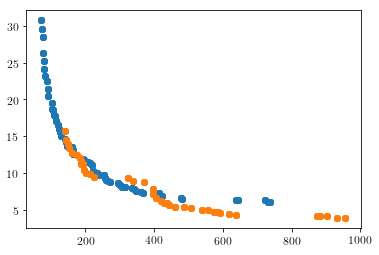

In [1504]:
plt.plot(W_p_L[0],dT_L[0][0],'o')
plt.plot(W_p_H[0],dT_H[0][0],'o')

In [1295]:
plt.plot(W_array_,Ec_final,'.')
plt.plot(W_p_F,Ec_p_F,'x')

#plt.plot(W_t_L,Ec_array_L,'.')
#plt.plot(W_p_L,Ec_p_L,'x')

plt.grid()
plt.xlabel('$\dot{W}_\mathrm{T}$ [W]')
plt.ylabel('$\epsilon C_\mathrm{r}$ [-]')
plt.show()
plt.savefig('Fan_Both_mf_2400.pdf',format = 'pdf', dpi=500,bbox_inches='tight')

NameError: name 'W_array_' is not defined

In [ ]:
aux = arange(0,600,1)

plt.plot(W_p_F,Ec_p_F,'x')
plt.plot(aux,(0.14/450)*array(aux)+0.04-14/450)
plt.grid()
plt.xlabel('$\dot{W}_\mathrm{T}$ [W]')
plt.ylabel('$\epsilon C_\mathrm{r}$ [-]')

plt.xlim([80,580])
plt.ylim([0.03,0.19])
plt.show()
#plt.savefig('Fan_Both_mf_2400_Paretto.pdf',format = 'pdf', dpi=500,bbox_inches='tight')

In [ ]:
plt.plot(W_p_c_array/m_f/100,'o',label = 'Hot')
plt.plot(W_p_h_array/m_f/100,'o', label = 'Cold')
plt.legend()

In [233]:
W = []
Ec = []
Eh = []
Re_dc = []
dP = []

for i in range(len(N_r)):
    A = HEx(Xl,Xt,N_r[i],N_l,L1,Di,De,pf,xf,sigmaf,sigmah,pd,m_f)
    W.append(A[0])
    Ec.append(A[1])
    Eh.append(A[2])
    Re_dc.append(A[3])
    dP.append(A[4])

5.693898462958798 200.0 5.0
5.696257913842089 200.0 5.0
5.698528461412103 200.0 5.0
5.7007150375238025 200.0 5.0
5.702822215866444 200.0 5.0
5.704854243897611 200.0 5.0
5.706815071420374 200.0 5.0
5.708708376208279 200.0 5.0
5.7105375870278285 200.0 5.0
5.712305904361795 200.0 5.0
5.714016319096771 200.0 5.0


In [262]:

A[0]

fan(2250*0.588578,A[0][0],A[0][1],A[0][2])

-0.535714334967782

In [288]:
aux = fan(VFR,A[0][0],A[0][1],A[0][2])-dP[0]
inter = np.abs(aux).argmin()


1210

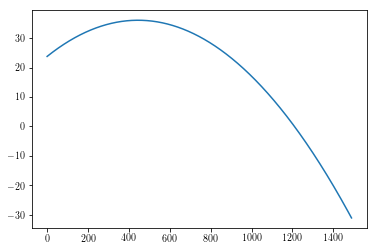

In [277]:
plt.plot(aux)

[]

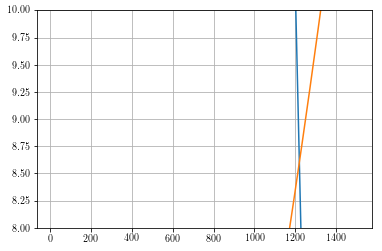

In [285]:
dP_v = np.array([37,35,30,22,11,0])
V  = np.array([1000,1250,1500,1750,2000,2250])*0.588578
A = curve_fit(fan,V,dP_v,maxfev=10000)
VFR = np.arange(10,1500,1)
plt.plot(VFR,fan(VFR,A[0][0],A[0][1],A[0][2]))
plt.plot(VFR,dP[0])
plt.ylim([8,10])
plt.grid()
plt.plot()

https://www.ebmpapst.com/en/products/axial-fans/axialfansdetail.php?pID=139216

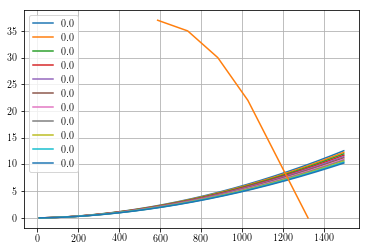

In [239]:
for i in range(len(N_r)):
    plt.plot(VFR,dP[i],label = str(round(N_r[i])))
plt.plot(V,dP_v)
plt.legend()
plt.grid()

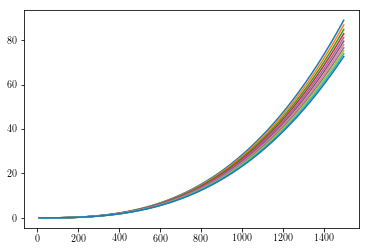

In [240]:
for i in range(len(N_r)):
    plt.plot(VFR,W[i],label = str(round(N_r[i])))
    #plt.ylim([0,50])

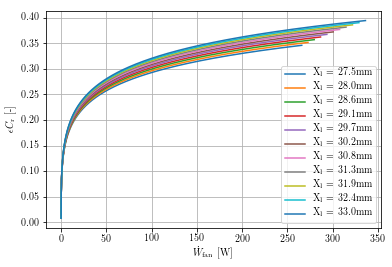

In [222]:
for i in range(len(N_r)):
    plt.plot(W[i],Ec[i],label = r'X$_\mathrm{l}$ = ' + str(round(N_r[i]*1000,1)) + 'mm')
plt.legend()
plt.xlabel('$\dot{W}_\mathrm{fan}$ [W]')
plt.ylabel('$ \epsilon C_\mathrm{r}$ [-]')
plt.grid()
#plt.savefig('X_l.pdf',format = 'pdf', dpi=500,bbox_inches='tight')

In [11]:
Di = 0.15
m_f = 2000/3600
A_min_i = np.pi*(0.15**2)/4
G_i = m_f/A_min_i

mu_wc = 0.001138   #[kg/(m.s)] Viscosity in the cold line (15ºC)
mu_wh = 0.0007193 

Re_ic = G_i*Di/mu_wc 
Re_ih = G_i*Di/mu_wh 
Re_ic,Re_ih

(4143.850630525167, 6555.959985454802)

Constant inputs

In [1562]:
##Properties of the solid 

rho_s = 7900  #[kg/m3] Density of the solid
k_s   = 8 #[W/(m2.K)] #Thermal conductivity of the solid

## Propertis of the fluid

rho_f = 1000  #[kg/m3] Density of the fluid
c_f   = 4181  #[kJ/(kg.K)] # Specific heat of the fluid
Pr_f  = 6.136 #[-] Prandtl of the fluid
mu_f  = 0.0008901 #[kg/m-2] #Viscosity of the fluid
k_f   = 0.6065  #[W/(m2.K)] #Thermal conductivity of the fluid

## Porous medium
d_p = 500*10**(-6) #[m] Particle diameter
Epsilon = 0.45  #[-] Porosity

Properties Calculation

In [13]:
Prop = xlrd.open_workbook('La-Fe-Si.xlsx') #Import Properties File
SpecHeat = Prop.sheet_by_name('C') # #Import Specific Heat
dTad = Prop.sheet_by_name('dT') #Import Adiabatic Temperature Change

T_exp = dTad.col_values(0) #Import experimented temperatures 
B_exp = dTad.col_values(1) #Import experimented magnetic fields

T_arg = arange(min(T_exp),max(T_exp)+0.01,0.1)

K = len(dTad.col_values(0)) #Import data number

T_l = arange(270,315,2)#ture of Curie of the multilayer
N_ml = len(T_l) #Number of Multilayer Layers



dT = zeros([N_ml,K])
C = zeros([N_ml,K])
for i in range(N_ml):
    dT[i,:] = (dTad.col_values(i+2))    #Data of Adiabatic Temperature change
    C[i,:] = (SpecHeat.col_values(i+2)) #Data of specific heat

In [14]:
T_layer = arange(283,313.1,30/14)
L_layer = 100/len(T_layer)*ones(len(T_layer))

Importing AMR simulation inputs

In [1549]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx') #Import inputs File
Inputs = Data.sheet_by_name('Data') 

L   = array(Inputs.col_values(0)) #Import AMR Length [mm]
H   = array(Inputs.col_values(1)) #Import AMR Height [mm]
W   = array(Inputs.col_values(2)) #Import AMR Width [mm]
T_c = array(Inputs.col_values(3)) #Import temperature span [K]
T_h = array(Inputs.col_values(4)) #Import temperature span [K]
B   = array(Inputs.col_values(5)) #Import magnetic field [T]
f   = array(Inputs.col_values(6)) #Import frequency [Hz]
m_f = array(Inputs.col_values(7)) #Import mass flow rate [kg/h]
Q_c = array(Inputs.col_values(8)) #Import Cooling capacity [W]
Q_h = array(Inputs.col_values(9)) #Import Rejected heat [W]
W_p = array(Inputs.col_values(10)) #Import Pumping power [W]
W_m = array(Inputs.col_values(11)) #Import Magnetic power [W]

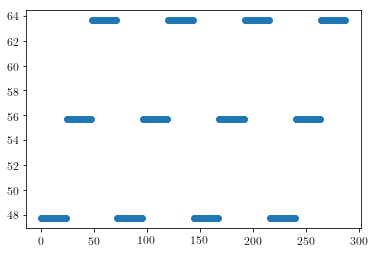

In [1556]:
plt.plot(W,'o')

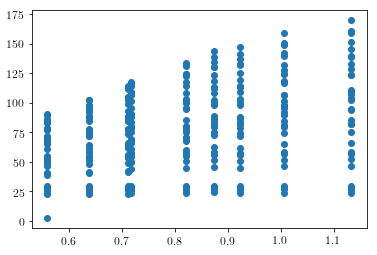

In [1567]:
plt.plot(m_s,Q_c,'o')

Calculation

In [1563]:
#Porous medium
m_s   = L*W*H*10**-9*(1-Epsilon)*rho_s #mass of the AMR
Beta = (1-Epsilon)*6/d_p
v_s   = (m_f/3600)/(rho_f*W*H*10**-6) #Superficial velocity

#Dimensionless Numbers
Re_dp = d_p*v_s*rho_f/((1-Epsilon)*mu_f) #Reynolds number
Nu = 2*(1+4*(1-Epsilon)/Epsilon)+((1-Epsilon)**0.5)*Re_dp**0.6*Pr_f**(1/3) # Nusselt number
Pe = Re_dp*Pr_f

h_int = Nu*k_f/d_p

#Effective conduction
k_e_f = k_f*Epsilon #Fluid effective conduction


a_0 = exp(-1.084-6.778*(Epsilon-0.298))
f_0 = 0.8
k_e_s = k_f*((1-a_0)*(Epsilon*f_0+(1-Epsilon*f_0)*k_s/k_f)/(1-Epsilon*(1-f_0)+k_s/k_f*Epsilon*(1-f_0))+a_0*(2*((k_s/k_f)**2)*(1-Epsilon)+(1+2*Epsilon)*k_s/k_f)/((2+Epsilon)*k_s/k_f+(1-Epsilon))) #Solid effective conduction

D_ = (k_f*rho_f/c_f)*0.75*Pe/2

k_s_eff = k_e_s
k_f_eff = k_e_f + rho_f*c_f*D_

In [17]:
C_H = zeros(len(L))
C_L = zeros(len(L))
dT_mg = zeros(len(L))
dT_dmg = zeros(len(L))
CdT_mg = zeros(len(L))
CdT_dmg = zeros(len(L))

In [18]:
for i in range(len(L)):
    print(i)
    C_H[i],C_L[i],dT_mg[i],dT_dmg[i],CdT_mg[i],CdT_dmg[i] = Metrics (SpecHeat,dTad,0,B[i],T_arg,N_ml,T_h[i],T_c[i],T_l,T_layer,L_layer)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Porous Medium Eff

In [19]:
NTU_f  = h_int*Beta*(L*W*H*10**(-9))/(m_f/3600*c_f) 
#NTU_HB = h_int*Beta*(L*W*H*10**(-9))/(m_s*C_H*f)
#NTU_CB = h_int*Beta*(L*W*H*10**(-9))/(m_s*C_L*f)

Eff = Data.sheet_by_name('Eff') 

Effect = []

for i in range(7):
     Effect.append(array(Eff.col_values(i)))

phi = np.arange(0.1,2.01,0.1)
NTU = np.arange(50,351,50)
NN,PP = np.meshgrid(NTU,phi)

Effectiv = interpolate.interp2d(phi,NTU,Effect,kind = 'linear')

Model Parameters - Similarity

In [20]:
Pi_1 = k_s_eff*(T_h-T_c)/(rho_s*f*L**2*CdT_dmg)
Pi_2 = Epsilon/(1-Epsilon)*k_f_eff*(T_h-T_c)/(rho_s*f*L**2*CdT_dmg)
Pi_3 = W_p/(m_s*f*CdT_dmg)
Pi_4 = CdT_mg/CdT_dmg
Pi_5 = h_int*Beta/(f*rho_s*CdT_dmg) #dT_sf unknown
Pi_6 = ((m_f/3600)*c_f)/(m_s*C_L*f)
Pi_7 = (T_h-T_c)/(dT_dmg)

Pi_8 = Q_c/(m_s*f*CdT_dmg)
Pi_9 = Q_h/(m_s*f*CdT_dmg)
Pi_10 = W_m/(m_s*f*CdT_dmg)

Efness_HB = zeros(len(Pi_6))
Efness_CB = zeros(len(Pi_6))

for i in range(len(Pi_6)):
    Efness_HB[i] = Effectiv(Pi_6[i]/2,NTU_f[i])
    Efness_CB[i] = Effectiv(Pi_6[i]/(2*Pi_4[i]),NTU_f[i])

Model Parameters - Integral

In [21]:
Q_pas_CB = Efness_CB*(T_h - T_c)*m_f*c_f
Q_act_CB = dT_mg*m_f*c_f
Q_span = (T_h - T_c)*m_f*c_f
Q_cond = ((1-Epsilon)*k_s_eff + Epsilon*k_f_eff)*(W*H*10**-6)*(T_h-T_c)/L
W_mag  = m_s*f*(CdT_mg - CdT_dmg)

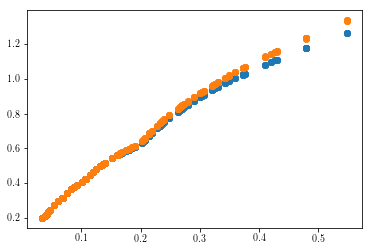

In [22]:
plt.plot(Pi_6,30*(1-Efness_HB),'o')
plt.plot(Pi_6,30*(1-Efness_CB),'o')

In [23]:
def fitting(X,a,b,c,d): 
    P1,P2= X
    return ((a*(P1**b)+c*(P1*P2)**(d)))

In [24]:
def fitting_W(X,a,b,c,d,e): 
    P1,P2= X
    return ((a*(P1**b)*P2**c)+d*(P1*P2)**e)

In [25]:
def fit_int(X,a,b,c,d,e,f,g,h): 
    P1,P2,P3,P4,P5,P6,P7= X
    return (a*(P1**b)*(P2**0)*(P3**0)*(P4**0)*(P5**0)*(P6**0)*(P7**0))

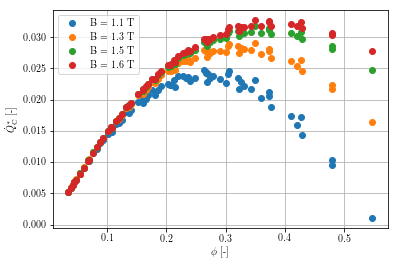

In [26]:
plt.plot(Pi_6[0:72],Pi_8[0:72],'o',label = 'B = 1.1 T')
plt.plot(Pi_6[72:144],Pi_8[72:144],'o',label = 'B = 1.3 T')
plt.plot(Pi_6[144:216],Pi_8[144:216],'o',label = 'B = 1.5 T')
plt.plot(Pi_6[216:288],Pi_8[216:288],'o',label = 'B = 1.6 T')
plt.grid()
plt.xlabel('$\phi$ [-]')
plt.ylabel('$\dot{Q}_\mathrm{C}^*$ [-]')
plt.legend()
plt.show()

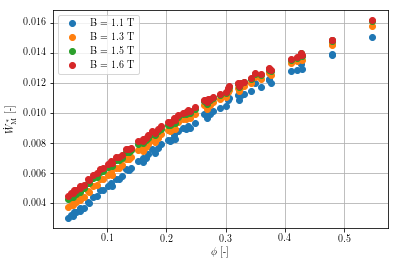

In [27]:
plt.plot(Pi_6[0:72],Pi_10[0:72],'o',label = 'B = 1.1 T')
plt.plot(Pi_6[72:144],Pi_10[72:144],'o',label = 'B = 1.3 T')
plt.plot(Pi_6[144:216],Pi_10[144:216],'o',label = 'B = 1.5 T')
plt.plot(Pi_6[216:288],Pi_10[216:288],'o',label = 'B = 1.6 T')
plt.grid()
plt.xlabel('$\phi$ [-]')
plt.ylabel('$\dot{W}_\mathrm{M}^*$ [-]')
plt.legend()
plt.show()

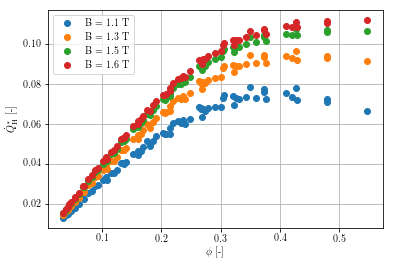

In [28]:
plt.plot(Pi_6[0:72],Pi_9[0:72],'o',label = 'B = 1.1 T')
plt.plot(Pi_6[72:144],Pi_9[72:144],'o',label = 'B = 1.3 T')
plt.plot(Pi_6[144:216],Pi_9[144:216],'o',label = 'B = 1.5 T')
plt.plot(Pi_6[216:288],Pi_9[216:288],'o',label = 'B = 1.6 T')
plt.grid()
plt.xlabel('$\phi$ [-]')
plt.ylabel('$\dot{Q}_\mathrm{H}^*$ [-]')
plt.legend()
plt.show()

In [29]:
a = 0*72
b = 4*72

In [30]:
Coef_Wm = curve_fit(fitting_W,(Pi_6[a:b],Pi_4[a:b]),Pi_10[a:b],maxfev=10000)
Coef_Wm

(array([ 1.85012325e-03,  5.75123981e-01, -1.10499621e+01,  1.57263317e-07,
        -2.36039012e+00]),
 array([[ 3.87577581e-08,  4.48498378e-08,  9.27514527e-05,
          6.29378809e-13,  9.99196077e-07],
        [ 4.48498378e-08,  3.85086670e-05, -8.11031449e-05,
          1.81533317e-09,  3.15612136e-03],
        [ 9.27514527e-05, -8.11031449e-05,  2.22964344e-01,
         -6.33240688e-09, -1.11758768e-02],
        [ 6.29378809e-13,  1.81533317e-09, -6.33240688e-09,
          1.54043677e-13,  2.74427797e-07],
        [ 9.99196077e-07,  3.15612136e-03, -1.11758768e-02,
          2.74427797e-07,  4.90156729e-01]]))

NameError: name 'Coef' is not defined

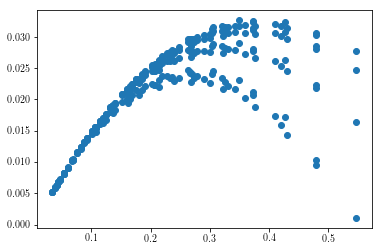

In [31]:
plt.plot(Pi_6[a:b],Pi_8[a:b],'o')
plt.plot(Pi_6[a:b],fitting((Pi_6[a:b],Pi_4[a:b]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]),'o')

In [ ]:
plt.plot(Pi_6[a:b],Pi_9[a:b],'o')
plt.plot(Pi_6[a:b],fitting((Pi_6[a:b],Pi_4[a:b]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]),'o')

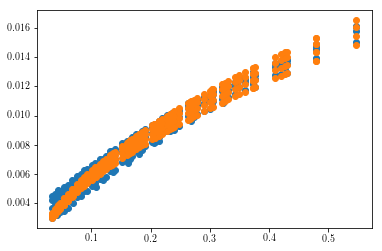

In [32]:
plt.plot(Pi_6[a:b],Pi_10[a:b],'o')
plt.plot(Pi_6[a:b],fitting_W((Pi_6[a:b],Pi_4[a:b]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],0,Coef_Wm[0][4]),'o')

In [33]:
erro1 = abs((Pi_8 - fitting((Pi_6[a:b],Pi_4[a:b]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]))/Pi_8*100)
erro2 = abs((Pi_9 - fitting((Pi_6[a:b],Pi_4[a:b]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]))/Pi_9*100)
erro3 = abs((Pi_10 - fitting_W((Pi_6[a:b],Pi_4[a:b]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],Coef_Wm[0][3],Coef_Wm[0][4]))/Pi_10*100)
j=0
h=0
k=0
for i in range(len(erro1)):
    if erro1[i] >= 10:
        j = j+1
    if erro2[i] >= 10:
        h = h+1
    if erro3[i] >= 10:
        k = k+1
j/len(erro1),h/len(erro2),k/len(erro3)

NameError: name 'Coef' is not defined

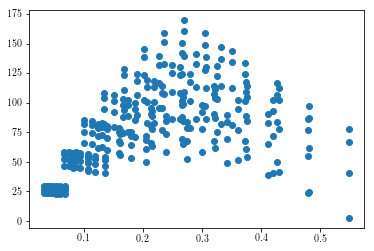

In [34]:
plt.plot(Pi_6,Q_c,'o')

In [35]:
plt.plot(Pi_6,erro1,'o')
plt.ylim([0,25])

NameError: name 'erro1' is not defined

In [36]:
plt.plot(Pi_6,erro1,'o',label = '$\dot{Q}_\mathrm{C}$')
plt.plot(Pi_6,erro2,'o',label = '$\dot{Q}_\mathrm{H}$')
plt.plot(Pi_6,erro3,'o',label = '$\dot{W}_\mathrm{M}$')
plt.ylim(0,30)
plt.xlabel('$\phi$ [-]')
plt.legend()
plt.ylabel('Error [$\%$]')
plt.grid()

NameError: name 'erro1' is not defined

In [37]:
plt.plot(Pi_6,erro3,'o')

NameError: name 'erro3' is not defined

In [38]:
plt.plot(Pi_8,fitting((Pi_6,Pi_7),Coef[0][0],Coef[0][1],Coef[0][2]),'o')
plt.plot(Pi_8,0.9*Pi_8)
plt.plot(Pi_8,1.1*Pi_8)
plt.grid()

NameError: name 'Coef' is not defined

In [ ]:
error_bar = np.arange(0,700)

In [124]:
K = (m_s*f*CdT_dmg)
plt.plot(Pi_8[0:72]*K[0:72],K[0:72]*fitting((Pi_6[0:72],Pi_4[0:72]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]),'o', label = 'B = 1.1 T')
plt.plot(Pi_8[72:2*72]*K[72:2*72],K[72:2*72]*fitting((Pi_6[72:2*72],Pi_4[72:2*72]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]),'X', label = 'B = 1.3 T')
plt.plot(Pi_8[2*72:3*72]*K[2*72:3*72],K[2*72:3*72]*fitting((Pi_6[2*72:3*72],Pi_4[2*72:3*72]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]),'s', label = 'B = 1.5 T')
plt.plot(Pi_8[3*72:4*72]*K[3*72:4*72],K[3*72:4*72]*fitting((Pi_6[3*72:4*72],Pi_4[3*72:4*72]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]),'^', label = 'B = 1.6 T')
plt.plot(error_bar,0.92*error_bar,'k--')
plt.plot(error_bar,1.08*error_bar,'k--')
plt.text(100,80,'- 8\%')
plt.text(80,110,'+ 8\%')


plt.xlabel('Numerical Cooling Capacity [W]')
plt.ylabel('Fitting Cooling Capacity [W]')

plt.grid()
plt.legend()
plt.xlim(0,180)
plt.ylim(0,180)

NameError: name 'm_s' is not defined

In [ ]:
plt.plot((Pi_9*K)[0:72],K[0:72]*fitting((Pi_6[0:72],Pi_4[0:72]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]),'o', label = 'B = 1.1 T')
plt.plot((Pi_9*K)[72:2*72],K[72:144]*fitting((Pi_6[72:2*72],Pi_4[72:2*72]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]),'X', label = 'B = 1.3 T')
plt.plot((Pi_9*K)[2*72:3*72],K[144:216]*fitting((Pi_6[2*72:3*72],Pi_4[2*72:3*72]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]),'s', label = 'B = 1.5 T')
plt.plot((Pi_9*K)[3*72:4*72],K[216:288]*fitting((Pi_6[3*72:4*72],Pi_4[3*72:4*72]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]),'^', label = 'B = 1.6 T')
plt.plot(error_bar,0.9*error_bar,'k--')
plt.plot(error_bar,1.1*error_bar,'k--')
plt.text(300,230,'- 10\%')
plt.text(250,350,'+ 10\%')


plt.xlabel('Numerical Rejected Heat [W]')
plt.ylabel('Fitting Rejected Heat [W]')

plt.grid()
plt.legend()
plt.xlim(20,550)
plt.ylim(20,550)

In [ ]:
plt.plot((Pi_10*K)[0:72],K[0:72]*fitting_W((Pi_6[0:72],Pi_4[0:72]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],Coef_Wm[0][3],Coef_Wm[0][4]),'o', label = 'B = 1.1 T')
plt.plot((Pi_10*K)[72:2*72],K[72:144]*fitting_W((Pi_6[72:2*72],Pi_4[72:2*72]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],Coef_Wm[0][3],Coef_Wm[0][4]),'X', label = 'B = 1.3 T')
plt.plot((Pi_10*K)[2*72:3*72],K[144:216]*fitting_W((Pi_6[2*72:3*72],Pi_4[2*72:3*72]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],Coef_Wm[0][3],Coef_Wm[0][4]),'s', label = 'B = 1.5 T')
plt.plot((Pi_10*K)[3*72:4*72],K[216:288]*fitting_W((Pi_6[3*72:4*72],Pi_4[3*72:4*72]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],Coef_Wm[0][3],Coef_Wm[0][4]),'^', label = 'B = 1.6 T')
plt.plot(error_bar,0.9*error_bar,'k--')
plt.plot(error_bar,1.1*error_bar,'k--')
plt.text(40,31.5,'- 8\%')
plt.text(31.5,45,'+ 8\%')


plt.xlabel('Numerical Magnetic Work[W]')
plt.ylabel('Fitting Magnetic Work [W]')

plt.grid()
plt.legend()
plt.xlim(5,70)
plt.ylim(5,70)